In [245]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from scipy.stats import mannwhitneyu, ttest_ind, levene, shapiro
import seaborn as sns
import matplotlib.pyplot as plt
from helpers import *

load_dotenv()
control_file = os.getenv('control_file')
test_file = os.getenv('test_file')
control_group = pd.read_csv(control_file, sep=';')
test_group = pd.read_csv(test_file, sep=';')
df = pd.concat([control_group, test_group])


note - all the helpers functions can be found in the helpers.py file in this folder

# EDA

Let's start by having a brief overview of the data

In [246]:
df.head() # look at the table

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [247]:
df.info() # get infos

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Campaign Name        60 non-null     object 
 1   Date                 60 non-null     object 
 2   Spend [USD]          60 non-null     int64  
 3   # of Impressions     59 non-null     float64
 4   Reach                59 non-null     float64
 5   # of Website Clicks  59 non-null     float64
 6   # of Searches        59 non-null     float64
 7   # of View Content    59 non-null     float64
 8   # of Add to Cart     59 non-null     float64
 9   # of Purchase        59 non-null     float64
dtypes: float64(7), int64(1), object(2)
memory usage: 5.2+ KB


In [248]:
# Check for missing values (total per column)
missing = df.isnull().sum()
missing = missing[missing > 0]  # Show only columns with missing values

print("\nMissing values:")
print(missing)

# Optional: percentage of missing values
missing_percent = df.isnull().mean() * 100
print("\nPercentage of missing values:")
print(missing_percent[missing_percent > 0].sort_values(ascending=False))


Missing values:
# of Impressions       1
Reach                  1
# of Website Clicks    1
# of Searches          1
# of View Content      1
# of Add to Cart       1
# of Purchase          1
dtype: int64

Percentage of missing values:
# of Impressions       1.666667
Reach                  1.666667
# of Website Clicks    1.666667
# of Searches          1.666667
# of View Content      1.666667
# of Add to Cart       1.666667
# of Purchase          1.666667
dtype: float64


In [249]:
# drop the missing value:
df.dropna(inplace=True)

In [250]:
# fix naming of columns
df.columns = (
    df.columns
    .str.replace('# of', '')
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)
df.columns


Index(['campaign_name', 'date', 'spend_[usd]', 'impressions', 'reach',
       'website_clicks', 'searches', 'view_content', 'add_to_cart',
       'purchase'],
      dtype='object')

In [251]:
# transform date into datetime format
df['date'] = pd.to_datetime(df['date'],format="%d.%m.%Y") # convert date
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 0 to 29
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   campaign_name   59 non-null     object        
 1   date            59 non-null     datetime64[ns]
 2   spend_[usd]     59 non-null     int64         
 3   impressions     59 non-null     float64       
 4   reach           59 non-null     float64       
 5   website_clicks  59 non-null     float64       
 6   searches        59 non-null     float64       
 7   view_content    59 non-null     float64       
 8   add_to_cart     59 non-null     float64       
 9   purchase        59 non-null     float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 5.1+ KB


Create new variable to see changes in the checkout conversion efficiency 

In [252]:
# create new column
df['checkout_conversion_rate'] = df['purchase']/df['add_to_cart']

Now we can visualize the data

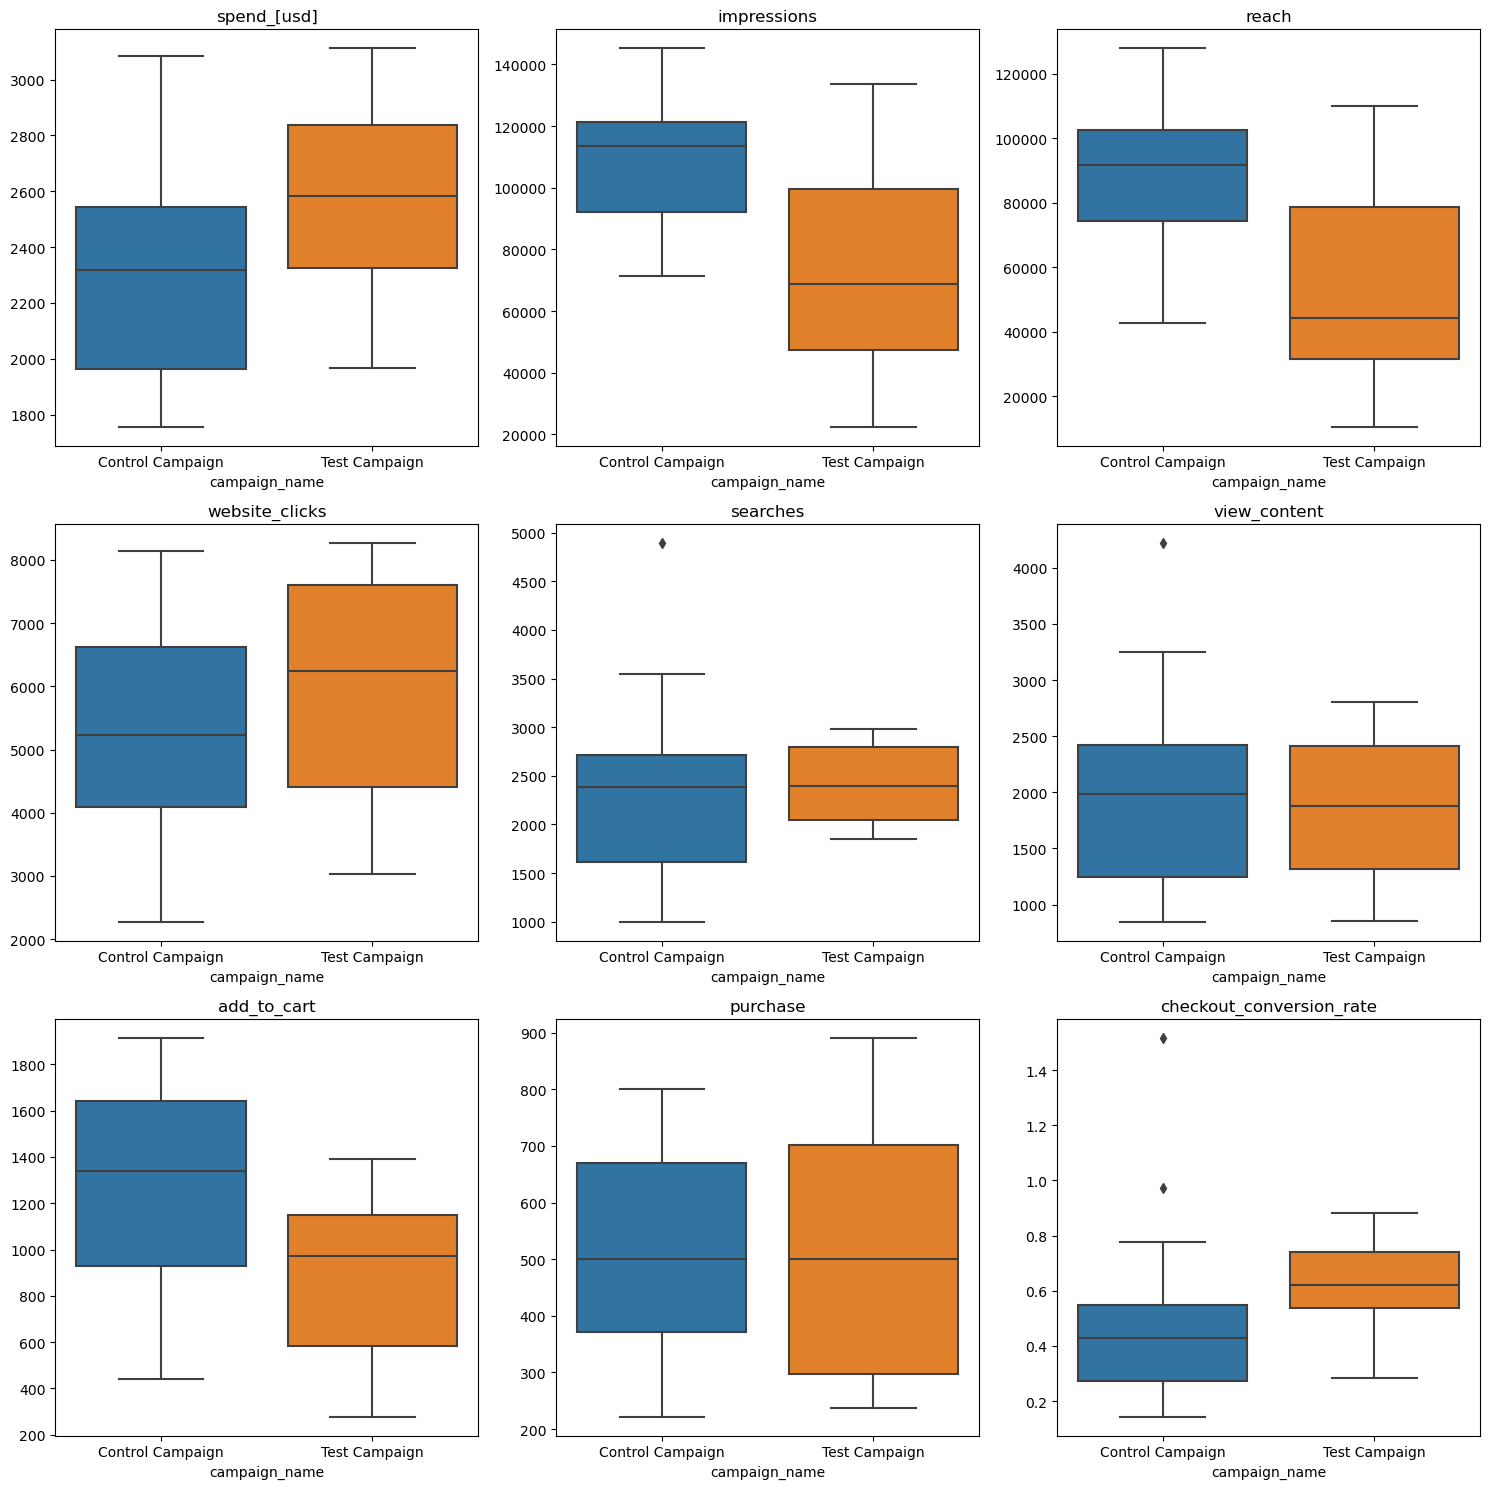

Spending
 campaign_name
Control Campaign    2304.068966
Test Campaign       2563.066667
Name: spend_[usd], dtype: float64
Reach
 campaign_name
Control Campaign    88844.931034
Test Campaign       53491.566667
Name: reach, dtype: float64
Add to Cart
 campaign_name
Control Campaign    1300.000000
Test Campaign        881.533333
Name: add_to_cart, dtype: float64
Purchase
 campaign_name
Control Campaign    522.793103
Test Campaign       521.233333
Name: purchase, dtype: float64
Checkout Conversion Rate
 campaign_name
Control Campaign    0.457179
Test Campaign       0.617949
Name: checkout_conversion_rate, dtype: float64


In [253]:
plot_numeric(df, sns.boxplot)
print('Spending\n',df.groupby('campaign_name')['spend_[usd]'].mean())
print('Reach\n',df.groupby('campaign_name')['reach'].mean())
print('Add to Cart\n',df.groupby('campaign_name')['add_to_cart'].mean())
print('Purchase\n',df.groupby('campaign_name')['purchase'].mean())
print('Checkout Conversion Rate\n',df.groupby('campaign_name')['checkout_conversion_rate'].mean())


From these plots we notice a few outliers in the data. We can also see that Spend, Checkout Conversion Rate and Website Clicks seem higher in the test campaigns, while impressions, reach and add to cart seems higher in the control campaing. 

In [254]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()
corr_matrix
# # Plotting the correlation matrix with a heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix')
# plt.show()



,spend_[usd],impressions,reach,website_clicks,searches,view_content,add_to_cart,purchase,checkout_conversion_rate
spend_[usd],1.000000,-0.061667,-0.111151,-0.057257,0.021775,-0.020850,-0.143060,0.031446,0.171059
impressions,-0.061667,1.000000,0.888076,-0.211908,-0.176981,-0.066400,0.279214,0.051899,-0.140381
reach,-0.111151,0.888076,1.000000,-0.271639,-0.126307,-0.035573,0.241364,0.038860,-0.116472
website_clicks,-0.057257,-0.211908,-0.271639,1.000000,0.369445,0.418337,-0.000277,-0.033163,-0.039958
searches,0.021775,-0.176981,-0.126307,0.369445,1.000000,0.890481,0.029575,0.035524,-0.049143
view_content,-0.020850,-0.066400,-0.035573,0.418337,0.890481,1.000000,0.148539,0.059368,-0.128422
add_to_cart,-0.143060,0.279214,0.241364,-0.000277,0.029575,0.148539,1.000000,0.385706,-0.645604
purchase,0.031446,0.051899,0.038860,-0.033163,0.035524,0.059368,0.385706,1.000000,0.335874
checkout_conversion_rate,0.171059,-0.140381,-0.116472,-0.039958,-0.049143,-0.128422,-0.645604,0.335874,1.000000


From the correlation analysis we notice that Reach and Impression have high correlation, as well as View Content and Searches, so the A/B test will probably present similar results between these variables. 
We also notice that spending and add to cart have a weak negative correlation, and spending have purchase have a very weak correlation (so increase spending doesn't seem to necessarily increase purchase). However there is a slighly positive correlation between spending and conversion rate. 

To avoid skewing the A/B testing, let's remove the outliers

In [255]:
# check and remove outliers
numeric_cols = df.select_dtypes(include=["int",'float']).columns.to_list()
cleaned_df = remove_outliers_iqr(df, numeric_cols)
# check and remove the outliers

Row 28 → outlier in column 'searches' (value = 28    4891.0
28    1920.0
Name: searches, dtype: float64)
Row 28 → outlier in column 'view_content' (value = 28    4219.0
28    1240.0
Name: view_content, dtype: float64)
Row 29 → outlier in column 'checkout_conversion_rate' (value = 29    1.515837
29    0.553191
Name: checkout_conversion_rate, dtype: float64)


# A/B Test

Let's start by checking for normality, to understand if we'll use the T-test (if both groups are Normally Distributed) or the Mann-Whitney U test.

In [256]:
# check for normality
for col in numeric_cols:
    control = cleaned_df[cleaned_df["campaign_name"] == "Control Campaign"][col]
    test = cleaned_df[cleaned_df["campaign_name"] == "Test Campaign"][col]
    print(
        f"{col}: Control is {check_normality(control)} and Test is {check_normality(test)}"
    )

spend_[usd]: Control is Normal and Test is Normal
impressions: Control is Normal and Test is Normal
reach: Control is Normal and Test is Normal
website_clicks: Control is Normal and Test is Not Normal
searches: Control is Normal and Test is Not Normal
view_content: Control is Normal and Test is Normal
add_to_cart: Control is Normal and Test is Not Normal
purchase: Control is Normal and Test is Not Normal
checkout_conversion_rate: Control is Normal and Test is Normal


Now for the A/B test we will proceed as follows: 
Calculate Cohen's d to understand the size of the difference between the two groups
Then calculate the "ideal" sample size to get an 80% power level, which is something that in an ideal scenario we'd do beforehand
Then we run the A/B test that will use different test based on the normality and the variance of the samples
Lastly we check the post-hoc statistical power, to see the probability of avoiding Type II error (so failing to reject the null Hypotesis when the alternative Hypotesis is true).

#### **Spending**

Null Hypothesis (H0): The two campaigns have equal mean.  
Alternative Hypothesis (H1): Test campaign has higher mean than Control. 

In [257]:
# check ideal sample size
test = cleaned_df[cleaned_df["campaign_name"] == "Test Campaign"]

cohens_d = calculate_cohens_d(cleaned_df, 'spend_[usd]')

ideal_sample_size(cohens_d) # we would run this before

print(f'actual sample size: {len(test)}')

ab_test(cleaned_df, "spend_[usd]", alt="less")  # control < test

post_hoc_power(cohens_d,test, alternative='larger') # we run this to verify after

Cohen's d: 0.72
Required sample size per group: 31
actual sample size: 30
spend_[usd]: 0.004249949725509847 and we Reject H0
Power: 0.869


From here we can conclude that we spend more in a statistically significant way for the test campaign than for the control campaing.

#### **Reach**

Null Hypothesis (H0): The two campaigns have equal mean.  
Alternative Hypothesis (H1): The Control campaign has higher mean than Test. 

In [258]:
# check ideal sample size
test = cleaned_df[cleaned_df["campaign_name"] == "Test Campaign"]

cohens_d = calculate_cohens_d(cleaned_df, 'reach')

ideal_sample_size(cohens_d) # we would run this before

print(f'actual sample size: {len(test)}')

ab_test(cleaned_df, "reach", alt="greater")  # control < test

post_hoc_power(cohens_d,test, alternative='smaller') # we run this to verify after

Cohen's d: -1.39
Required sample size per group: 9
actual sample size: 30
reach: 1.478305454743173e-06 and we Reject H0
Power: 1.000


From the results we can conclude that the control campaign has higher reach than the test campaign. 

#### **Website Clicks**

Null Hypothesis (H0): The two campaigns have equal mean.  
Alternative Hypothesis (H1): The two campaigns have different mean. 

In [259]:
# check ideal sample size
test = cleaned_df[cleaned_df["campaign_name"] == "Test Campaign"]

cohens_d = calculate_cohens_d(cleaned_df, 'website_clicks')

ideal_sample_size(cohens_d) # we would run this before

print(f'actual sample size: {len(test)}')

ab_test(cleaned_df, "website_clicks", alt="two-sided")

post_hoc_power(cohens_d,test, alternative='two-sided') # we run this to verify after

Cohen's d: 0.46
Required sample size per group: 75
actual sample size: 30
website_clicks: 0.09489354683695694 and we Fail to Reject H0
Power: 0.417


From this test we do not have enough evidence to show any statistical difference in Website Clicks. The low power level shows that we also have a high chance of failing to reject H0, so it would be recommended to gather more data around this. 

#### **Searches**

Null Hypothesis (H0): The two campaigns have equal mean.  
Alternative Hypothesis (H1): The two campaigns have different mean. 

In [260]:
# check ideal sample size
test = cleaned_df[cleaned_df["campaign_name"] == "Test Campaign"]

cohens_d = calculate_cohens_d(cleaned_df, 'searches')

ideal_sample_size(cohens_d) # we would run this before

print(f'actual sample size: {len(test)}')

ab_test(cleaned_df, "searches", alt="two-sided")

post_hoc_power(cohens_d,test, alternative='two-sided') # we run this to verify after

Cohen's d: 0.48
Required sample size per group: 70
actual sample size: 30
searches: 0.15723285240410945 and we Fail to Reject H0
Power: 0.441


From this test we do not have enough evidence to show any statistical difference in Searches. The low power level shows that we also have a high chance of failing to reject H0, so it would be recommended to gather more data around this. 

#### **Add to Cart**

Null Hypothesis (H0): The two campaigns have equal mean.  
Alternative Hypothesis (H1): Control campaign has higher mean than Test. 

In [261]:
# check ideal sample size
test = cleaned_df[cleaned_df["campaign_name"] == "Test Campaign"]

cohens_d = calculate_cohens_d(cleaned_df, 'add_to_cart')

ideal_sample_size(cohens_d) # we would run this before

print(f'actual sample size: {len(test)}')

ab_test(cleaned_df, "add_to_cart", alt="greater")  # control < test

post_hoc_power(cohens_d,test, alternative='smaller') # we run this to verify after

Cohen's d: -1.21
Required sample size per group: 12
actual sample size: 30
add_to_cart: 0.00018825808192811678 and we Reject H0
Power: 0.999


From this we can see that the control group seems to have statistically higher "add to cart" compared to test.

#### **Purchases**

Null Hypothesis (H0): The two campaigns have equal mean.  
Alternative Hypothesis (H1): The two campaigns have different mean. 

In [262]:
# check ideal sample size
test = cleaned_df[cleaned_df["campaign_name"] == "Test Campaign"]

cohens_d = calculate_cohens_d(cleaned_df, 'purchase')

ideal_sample_size(cohens_d) # we would run this before

print(f'actual sample size: {len(test)}')

ab_test(cleaned_df, "purchase", alt="two-sided")

post_hoc_power(cohens_d,test, alternative='two-sided') # we run this to verify after

Cohen's d: -0.02
Required sample size per group: 64690
actual sample size: 30
purchase: 0.9299480870617278 and we Fail to Reject H0
Power: 0.050


There is not enough data to reject H0 for the purchases, and we would need a much bigger sample size to increase the power for this variable. 

#### **Checkout Conversion Rate**

Null Hypothesis (H0): The two campaigns have equal mean.  
Alternative Hypothesis (H1): Test campaign has higher mean than Control. 

In [263]:
# check ideal sample size
test = cleaned_df[cleaned_df["campaign_name"] == "Test Campaign"]

cohens_d = calculate_cohens_d(cleaned_df, 'checkout_conversion_rate')

ideal_sample_size(cohens_d) # we would run this before

print(f'actual sample size: {len(test)}')

ab_test(cleaned_df, "checkout_conversion_rate", alt="less")  # control < test

post_hoc_power(cohens_d,test, alternative='larger') # we run this to verify after

Cohen's d: 1.12
Required sample size per group: 14
actual sample size: 30
checkout_conversion_rate: 4.436651229099713e-05 and we Reject H0
Power: 0.996


From this we can conclude that the new campaign seems to have a better conversion rate (cart to purchase) compared to the Control one

# Conclusions

From the A/B test we can observe that: 
1. Spending for the test campaign has increased
2. The control campaing has higher reach and impressions
3. The two campaigns show no difference in website clicks, searches or view content
4. The Control group has higher "add to cart" values than the Test, but with no statistically significant changes in purchases (difficult to confirm due to low sample size)

Given this data, it looks like the Test campaing **underperfomed on ROI metrics**, however it's notable that the overall conversion rate was substantially higher in the Test campaign. Given the Control campaign's broader reach, this might suggest that the **Test campaign has improved targeting** compared to the Control one. 

